### Basis Swap Par Spreads

### Bootstrapping technique to derive discount curve

The first step of our project consists in extracting a discount curve (which is characterized by pillar dates and the corresponding discount factors) from OIS market data, via a process called bootstrapping.
Bootstrapping describes a procedure used to calculate the zero-coupon yield curve from market figures.


In [7]:
from datetime import date
from finmarkets import DiscountCurve,OvernightIndexSwap,generate_swap_dates
from curve_data import euribor_3m_curve, euribor_6m_curve,euribor_1m_curve, discount_curve
from ois_data import basis_swaps, observation_date, quotes

### Description of the classes that we used

Before starting with our code, we imported some fundamental classes from the finmarkets file.
We started with the DiscountCurve class. The main attribute of this class are: 
-  a list pillar dates specifying the value dates of the given discount factors t0,....,tn.
- a list of given discount factors D(t0), ..., D(tn.
- a pricing date (' observation_date') which corresponds to t0.

Since the discount factor can be expressed as  $ D =  exp( -r ( T-t)) $ ,  we wrote a function called df for calculating a discount factor at any date, using log-linear interpolation. 

Moreover, the formula to calculate the forward rates can be found exploiting the no arbitrage condition $ (1 + r1T1) (1 + r1,2 (T2 - T1)) = 1 + r2T2 $

Another important class used is the OvernightIndexSwap. OIS are products which pay a floating coupon, determined by overnight rate fixings over the reference periods, against a fixed coupon.
By definition an OIS is defined by:
- a notional amount N
- a start date d0
- a sequence of payment dates d1, ..., dn
- a fixed rate K

Our goal will be to take a series of OIS quotations ('ois_data.quotes'), and determine the OIS's NPV given a certain discount curve. However, using the Bootstrapping technique we are going to somehow reverse this procedure. Therefore, the  final aim will be to get the discount curve such that it prices correctly each OIS ( by minimizing the sum of the square NPVs).

Finally, we imported generate_swap_ dates, a function which given a start date and the number of months,
returns a list of dates of annual frequency starting from the start date and ending after the specified
number of months.




In [8]:
d = {}
pillar_dates = [observation_date]
swaps = [] 
for quote in quotes:
    swap = OvernightIndexSwap(
    1e6,
    generate_swap_dates(
    observation_date,
    quote['maturity']
    ),
    0.01 * quote['rate']
    )
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])

pillar_dates = sorted(pillar_dates)
n_df_vector = len(pillar_dates)

type(pillar_dates), len(pillar_dates), pillar_dates[0], pillar_dates[-1]

def objective_function(x):
    curve = DiscountCurve(
        observation_date,
        pillar_dates,
        x
)
    sum_sq = 0.0
    for swap in swaps:
        sum_sq += swap.npv(curve) ** 2
    return sum_sq

from scipy.optimize import minimize
from matplotlib import pyplot as plt

x0 = [1.0 for i in range(n_df_vector)]

bounds = [(0.01, 100.0) for i in range(n_df_vector)]
bounds[0] = (1.0, 1.0)
result = minimize(objective_function, x0, bounds=bounds)

print(result.x)
discount_curve = DiscountCurve(observation_date, pillar_dates, result.x)
print(pillar_dates)


[1.         0.99999911 0.99999806 0.99999706 0.99999606 0.99999497
 0.99999388 0.99999278 0.99999163 0.99999025 0.9999889  0.99998743
 0.99998597 0.99998066 0.99997477 0.99996734 0.99995817 0.99989527
 0.99977965 0.99961638 0.99941133 0.99917491 0.99891281 0.99862888
 0.99832777 0.99801928 0.99770338 0.9967518  0.99529769 0.99395627
 0.99267086]
[datetime.date(2019, 10, 31), datetime.date(2019, 11, 30), datetime.date(2019, 12, 31), datetime.date(2020, 1, 31), datetime.date(2020, 2, 29), datetime.date(2020, 3, 31), datetime.date(2020, 4, 30), datetime.date(2020, 5, 31), datetime.date(2020, 6, 30), datetime.date(2020, 7, 31), datetime.date(2020, 8, 31), datetime.date(2020, 9, 30), datetime.date(2020, 10, 31), datetime.date(2021, 1, 31), datetime.date(2021, 4, 30), datetime.date(2021, 7, 31), datetime.date(2021, 10, 31), datetime.date(2022, 10, 31), datetime.date(2023, 10, 31), datetime.date(2024, 10, 31), datetime.date(2025, 10, 31), datetime.date(2026, 10, 31), datetime.date(2027, 10, 3

### What the minimization algorithm actually does:

- It starts with our initial guess of the parameters and compute the objective function value;
- Move the parameters to reduce the value of the objective function;
- Repeat above step until further changes of the parameters do not bring additional reduction of the objective function.

We can use a graph to check whether the minimization algorithm actually worked or not.

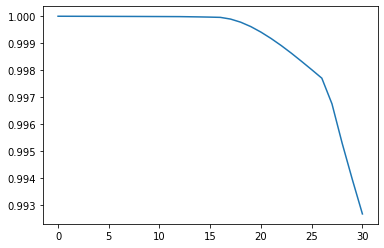

In [9]:
from matplotlib import pyplot as plt

plt.plot(result.x,)

### Par Spreads and NPV

A Tenor Basis Swap, also known as a floating-floating interest rate swap, is a financial instrument whereby floating cashflows from two different interest rates are exchanged, typically floating Libor indices of the same currency are exchanged e.g. 3M Libor vs 6M Libor cash- flows.

The contract parameters are:
- start date d0
- notional N
- floating rate long tenor (months) 
- floating rate short tenor (months)
- maturity (years)

The floating legs pay the reference LIBOR fixing at a frequency equal to the tenor of the floating rate.

The basis spread informs investors what adjustment or spread to add to the lower tenor Libor index so that the interest payments on both legs of the basis swap are equivalent.

We can easiy calculate S as:
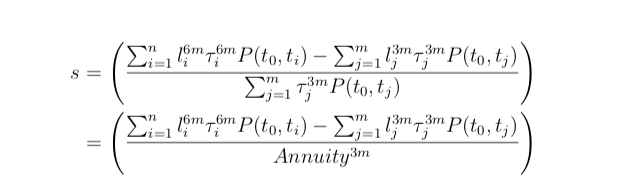

In the general case we write
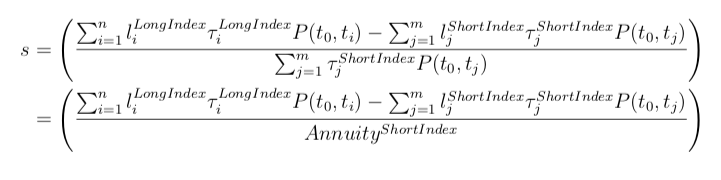

Where long index denotes the Libor index with the longer tenor and short index the Libor index with the shorter tenor.

In [10]:
class BasisSwap:
    
    def __init__(self, start_date, notional, first_tenor, second_tenor, maturity_years):
        self.notional = notional
        self.floating_leg_dates_1= generate_swap_dates(start_date, maturity_years, first_tenor)
        self.floating_leg_dates_2= generate_swap_dates(start_date, maturity_years, second_tenor)

        
    def annuity(self, discount_curve):
        a = 0
        for i in range(1, len(self.floating_leg_dates_1)):
            start_date = self.floating_leg_dates_1[i-1]
            end_date = self.floating_leg_dates_1[i]
            tau = (end_date - start_date).days / 360 
            a += discount_curve.df(self.floating_leg_dates_1[i]) * tau
        return a

    def swap_rate(self, discount_curve, short_tenor, long_tenor):
        s1= 0
        for k in range(1, len(self.floating_leg_dates_1)):
            F1 = short_tenor.forward_rate(self.floating_leg_dates_1[k-1])
            tau1 = (self.floating_leg_dates_1[k] - self.floating_leg_dates_1[k-1]).days / 360
            P1 = discount_curve.df(self.floating_leg_dates_1[k])
            s1 += F1 * tau1 * P1
        
        
        s2 = 0
        for j in range(1, len(self.floating_leg_dates_2)):
            F2 = long_tenor.forward_rate(self.floating_leg_dates_2[j-1])
            tau2 = (self.floating_leg_dates_2[j] - self.floating_leg_dates_2[j-1]).days / 360
            P2 = discount_curve.df(self.floating_leg_dates_2[j])
            s2 += F2 * tau2 * P2
        return(s2 - s1)/ self.annuity(discount_curve)
    
 
    def npv(self, discount_curve, short_tenor, long_tenor):
        npv1 = 0 # The NPV of the floating leg with shorter tenor is calculated as follows
        for k in range(1, len(self.floating_leg_dates_1)):
            F1 = short_tenor.forward_rate(self.floating_leg_dates_1[k-1])
            tau1 = (self.floating_leg_dates_1[k] - self.floating_leg_dates_1[k-1]).days / 360
            P1 = discount_curve.df(self.floating_leg_dates_1[k])
            par_spread = self.swap_rate(discount_curve, short_tenor, long_tenor)
            npv1 += (F1 + par_spread) * tau1 * P1
        
        npv2 = 0 # The NPV of the floating leg with longer tenor is calculated as follows
        for j in range(1, len(self.floating_leg_dates_2)):
            F2 = long_tenor.forward_rate(self.floating_leg_dates_2[j-1])
            tau2 = (self.floating_leg_dates_2[j] - self.floating_leg_dates_2[j-1]).days / 360
            P2 = discount_curve.df(self.floating_leg_dates_2[j])
            npv2 += F2 * tau2 * P2 
        return self.notional * (npv2 - npv1) #The NPV of the basis swap 
        #(seen from the point of view of the counterparty which receives the floating leg with longer tenor) 


Tenor Basis Swaps usually quote at par, meaning that the price of the swap is zero and that the PV or present value of each of the trade legs is the same. So in the case of a 3x6 Tenor basis swap the present value of the 3M Libor interest payments equals the present value of the 6ML payments. This is made possible by adding a basis spread s to the Libor Index with the lower frequency tenor in this case the 3M Libor leg.

 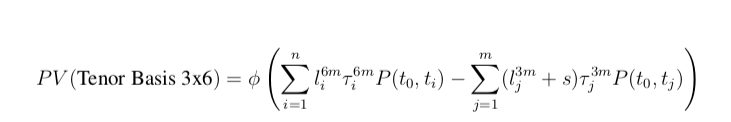
 
 In the general case we write
 
 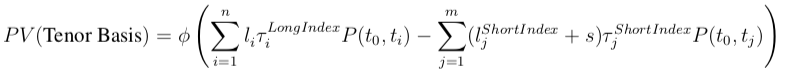
 
 

### Getting the data:

Finally, we computed the corresponding par spreads and NPVs of the basis_swaps in input. 
- 1x3 Tenor Basis Swap
- 1x6 Tenor Basis Swap
- 3x6 Tenor Basis Swap


In [11]:
bs = []
pv = []

for quote in basis_swaps:
    if quote['first_tenor'] == 1 and quote['second_tenor'] == 3:
        basis_s = BasisSwap(observation_date, quote['nominal'], quote['first_tenor'], quote['second_tenor'], quote['maturity'])
        par_spread = basis_s.swap_rate(discount_curve, euribor_1m_curve, euribor_3m_curve)
        NPV = basis_s.npv(discount_curve, euribor_1m_curve, euribor_3m_curve)
    elif quote['first_tenor'] == 1 and quote['second_tenor'] == 6:
        basis_s = BasisSwap(observation_date, quote['nominal'], quote['first_tenor'], quote['second_tenor'], quote['maturity'])
        par_spread = basis_s.swap_rate(discount_curve, euribor_1m_curve, euribor_6m_curve)
        NPV = basis_s.npv(discount_curve, euribor_1m_curve, euribor_6m_curve)

    elif quote['first_tenor'] == 3 and quote['second_tenor'] == 6:
        basis_s = BasisSwap(observation_date, quote['nominal'], quote['first_tenor'], quote['second_tenor'], quote['maturity'])
        par_spread = basis_s.swap_rate(discount_curve, euribor_3m_curve, euribor_6m_curve)
        NPV = basis_s.npv(discount_curve, euribor_3m_curve, euribor_6m_curve)
    bs.append(par_spread)
    pv.append(NPV)

print(bs)
print(pv)

[0.0002985881230106436, 0.001286552005328249, 0.0015851385661118445, 8.149339056614965e-05, 0.0012696016593209, 0.0013510928080064195, -4.9138851130294224e-05, 0.001217917685102786, 0.0011687710340889876, -7.812749623763695e-05, 0.0011749252594161171, 0.0010967852951873898, -9.280292864619027e-05, 0.0011315867184753822, 0.001038768009565462]
[-8.673617379884035e-13, 0.0, 0.0, 3.469446951953614e-12, 0.0, 0.0, 6.938893903907228e-12, -6.938893903907228e-12, 0.0, 4.163336342344337e-11, -2.7755575615628914e-11, 4.163336342344337e-11, 1.249000902703301e-10, -2.7755575615628914e-11, 8.326672684688674e-11]
